First 50 lines<br>
500 words<br>
tune hypers<br>
modify boiler plate code to split text by words instead of lines<br>

In [2]:
import tensorflow.keras as keras
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# Visualization
from IPython.display import display

import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

### Part 1
---

In [2]:
# Preprocessing - grab lines from the file
with open('PandP_Jane_Austen.txt', 'r', encoding='utf-8') as f:
     lines = f.read().split('\n')
# Paragraphs are separated by blank
# lines -> just drop those lines...
text = []
for i in range(len(lines)):
    if lines[i] != '':
        text = text + [lines[i]]
min_length = max([len(i) for i in text])
# Visual Confirmation that we have loaded the text in...
text[0:8]

['It is a truth universally acknowledged, that a single man in possession',
 'of a good fortune, must be in want of a wife.',
 'However little known the feelings or views of such a man may be on his',
 'first entering a neighbourhood, this truth is so well fixed in the minds',
 'of the surrounding families, that he is considered the rightful property',
 'of some one or other of their daughters.',
 '"My dear Mr. Bennet," said his lady to him one day, "have you heard that',
 'Netherfield Park is let at last?"']

In [3]:
# Unique characters - precalculated
with open('unique_chars.txt', 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')
lines = [line for line in lines if line != '']
# Integer code to symbol
itos = ['','',' ']
for i in lines:
    itos = itos + [i]
# Symbol to integer code
stoi = dict()
stoi['STOP'] = 0
stoi['START'] = 1
for i in range(2,len(itos)):
    stoi[itos[i]] = i

In [4]:
len(text)

10658

In [5]:
max(len(i) for i in text)+2

76

In [6]:
len(itos)

71

In [7]:
def encode_seq(x,mapping,min_length=0):
    # String to one-hot
    y = [mapping['START']]
    for i in list(x):
        y = y + [mapping[i]]
    y = y + [mapping['STOP']]
    # Stop-padding - handled elsewhere...
    while len(y) < min_length:
        y = y + [mapping['STOP']]
    return keras.utils.to_categorical(y,len(mapping))
def decode_seq(x,mapping):
    # One-hot to string
    y = []
    for i in x:
        y = y + [mapping[np.argmax(i)]]
    return ''.join(y)

In [8]:
temp = encode_seq(text[0],stoi)
temp = decode_seq(temp,itos)
temp

'It is a truth universally acknowledged, that a single man in possession'

In [9]:
# Encode that data
dataX = np.ones([len(text),max([len(i) for i in text])+2, len(itos)])

for i in range(len(text)):
    temp = encode_seq(text[i],stoi)
    dataX[i,0:len(temp),:] = temp
# Not strictly necessary, but I was trying some alternative strategies
# earlier and this is worth keeping around...
# This will be the same as dataX using this implementation...
dataY = np.ones([len(text),max([len(i) for i in text])+2,
 len(itos)])*(1.0/len(itos))
for i in range(len(text)):
    temp = encode_seq(text[i],stoi)
    dataY[i,0:len(temp),:] = temp

In [10]:
X = dataX[0:dataX.shape[0]-1,:,:]
Y = dataY[1:dataY.shape[0],:,:]
preY = Y[:,0:Y.shape[1]-1,:]
postY = Y[:,1:Y.shape[1],:]

In [11]:
nlines = 50
X = X[0:nlines,:,:]
Y = Y[0:nlines,:,:]
preY = preY[0:nlines,:,:]
postY = postY[0:nlines,:,:]
print(X.shape)
print(Y.shape)
print(preY.shape)
print(postY.shape)

(50, 76, 71)
(50, 76, 71)
(50, 75, 71)
(50, 75, 71)


In [22]:
# Size of the gestalt, context representations...
hidden_size = 800

## Encoder Construction
encoder_input = keras.layers.Input(shape=(None, X.shape[2]))
encoder_hidden = keras.layers.LSTM(hidden_size, return_state=True)
# Tie the hidden layer to the input layer (passed in)
encoder_output, enc_state_h, enc_state_c = encoder_hidden(encoder_input)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [enc_state_h, enc_state_c]


## Decoder Construction
# Set up the decoder, using `encoder_states` as initial state.
decoder_input = keras.layers.Input(shape=(None, preY.shape[2]))
decoder_hidden = keras.layers.LSTM(hidden_size,
 return_sequences=True,
 return_state=True)
# Connect hidden to input (also reads from the encoder...)
decoder_hidden_output, decoder_state_h, decoder_state_c = decoder_hidden(
 decoder_input, initial_state=encoder_states)
decoder_dense = keras.layers.Dense(postY.shape[2], activation='softmax')
# Connect output to hidden
decoder_output = decoder_dense(decoder_hidden_output)


# Our functional API model now has -two- input layers:
# 1. Reads from X
# 2. Reads from preY
# and has a -single- output layer...
# 1. Targets are postY
model = keras.Model([encoder_input, decoder_input], decoder_output)


# Compile it...
model.compile(loss=keras.losses.CategoricalCrossentropy(),
 optimizer=keras.optimizers.Adam(),
 metrics=[keras.metrics.CategoricalAccuracy()])
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, None, 71)]   0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, None, 71)]   0                                            
__________________________________________________________________________________________________
lstm_6 (LSTM)                   [(None, 800), (None, 2790400     input_7[0][0]                    
__________________________________________________________________________________________________
lstm_7 (LSTM)                   [(None, None, 800),  2790400     input_8[0][0]                    
                                                                 lstm_6[0][1]               

In [23]:
total = 0

In [26]:
batch_size = 76
epochs = 300
history = model.fit([X,preY], postY,
 batch_size=batch_size,
 epochs=epochs,
 verbose=0)
print('Accuracy:',model.evaluate([X,preY],postY)[1]*100.0,'%')
total += epochs
print(total)

2/2 [==============================] - 0s 13ms/step - loss: 1.1384 - categorical_accuracy: 0.8371
Accuracy: 83.7066650390625 %
600


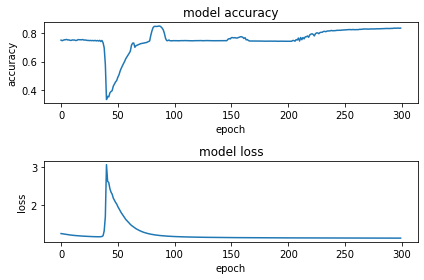

In [27]:
plt.figure(1)
# summarize history for accuracy
plt.subplot(211)
plt.plot(history.history['categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')

# summarize history for loss
plt.subplot(212)
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.tight_layout()
plt.show()

In [28]:
# Your encoder_model and decoder_model here!
## Testing - Again, separate the encoder-decoder for teacher forcing...
# Part 1 - make the encoder
# Make just a model out of the encoder
# input = encoder_input (Input layer)
# output = encoder_states (enc Hidden layer * 2)
encoder_model = keras.Model(encoder_input, encoder_states)
# Part 2 - make the decoder
# Make just a model out of the decoder
# input = encoder_states (enc Hidden layer * 2)
# output = decoder_output
decoder_state_input_h = keras.layers.Input(shape=(hidden_size,))
decoder_state_input_c = keras.layers.Input(shape=(hidden_size,))
# Connect hidden to input(s)
decoder_states_input = [decoder_state_input_h, decoder_state_input_c]
decoder_hidden_output, decoder_state_h, decoder_state_c = decoder_hidden(
 decoder_input, initial_state=decoder_states_input)
decoder_states = [decoder_state_h, decoder_state_c]
# Connect output to hidden(s)
decoder_output = decoder_dense(decoder_hidden_output)
decoder_model = keras.Model(
 [decoder_input] + decoder_states_input,
 [decoder_output] + decoder_states)

In [29]:
# Get the gestalt context for the input sequence(s)
i = 0
context = encoder_model.predict(X[i:i+1,:,:])
# Prep a starting token...
token = encode_seq('',stoi)[0].reshape(1,1,len(stoi))
token

array([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0.]]], dtype=float32)

In [30]:
# What should we see?
print('Input:', text[i])
print('Output:', text[i+1])

Input: It is a truth universally acknowledged, that a single man in possession
Output: of a good fortune, must be in want of a wife.


In [31]:
result = np.zeros([1,postY.shape[1],postY.shape[2]])
for x in range(postY.shape[1]):
    out,h,c = decoder_model.predict([token]+context)
    token = np.round(out)
    context = [h,c]
    result[:,x,:] = token
decode_seq(result[0,:,:],itos)

'own on Monday in a chaise and four to see the place, and was so much'

In [32]:
# Iterate - teacher forcing through each line
for i in range(0,50):
    # Get the gestalt context for the input sequence(s)
    context = encoder_model.predict(X[i:i+1,:,:])
    # Prep a starting token...
    token = encode_seq('',stoi)[0].reshape(1,1,len(stoi))
    result = np.zeros([1,postY.shape[1],postY.shape[2]])
    for x in range(postY.shape[1]):
        out,h,c = decoder_model.predict([token]+context)
        token = np.round(out)
        context = [h,c]
        result[:,x,:] = token
    print('Txt:',text[i+1])
    print('Net:',decode_seq(result[0,:,:],itos))

Txt: of a good fortune, must be in want of a wife.
Net: own on Monday in a chaise and four to see the place, and was so much
Txt: However little known the feelings or views of such a man may be on his
Net: However little known the feelings or views of such a man may be on his
Txt: first entering a neighbourhood, this truth is so well fixed in the minds
Net: s  an man s , fre oow nas may lnken of h mand no thes no
Txt: of the surrounding families, that he is considered the rightful property
Net: own-up daughters, she ought to give over thinking of her own beauty."
Txt: of some one or other of their daughters.
Net: own-up daughters, she ought to give over thinking of her own beauty."
Txt: "My dear Mr. Bennet," said his lady to him one day, "have you heard that
Net: "My dear Mr. Bennet," said his lady to him one day, "have you heard that
Txt: Netherfield Park is let at last?"
Net: own-up daughters, she ought to give over thinking of her own beauty."
Txt: Mr. Bennet replied that he had not

In [33]:
# Iterate - but no teaching forcing past first line...
# Get the gestalt context for the input sequence
i = 0
context = encoder_model.predict(X[i:i+1,:,:])
for i in range(0,50):
    # Prep a starting token...
    token = encode_seq('',stoi)[0].reshape(1,1,len(stoi))

    result = np.zeros([1,postY.shape[1],postY.shape[2]])
    for x in range(postY.shape[1]):
        out,h,c = decoder_model.predict([token]+context)
        token = np.round(out)
        context = [h,c]
        result[:,x,:] = token
    print('Txt:',text[i+1])
    print('Net:',decode_seq(result[0,:,:],itos))
    # CRUCIAL -> keep predicted result instead of teacher forcing!
    context = encoder_model.predict(result)

Txt: of a good fortune, must be in want of a wife.
Net: own on Monday in a chaise and four to see the place, and was so much
Txt: However little known the feelings or views of such a man may be on his
Net: onnesheo st be o thi gerrt iire iiin of."
Txt: first entering a neighbourhood, this truth is so well fixed in the minds
Net: onnesheo st be o thi gerr ir ingin of them."
Txt: of the surrounding families, that he is considered the rightful property
Net: onnesheo st be o thi gerr ir ingin of them."
Txt: of some one or other of their daughters.
Net: onnesheo st be o thi gerr ir ingin of them."
Txt: "My dear Mr. Bennet," said his lady to him one day, "have you heard that
Net: onnesheo st be o thi gerr ir ingin of them."
Txt: Netherfield Park is let at last?"
Net: onnesheo st be o thi gerr ir ingin of them."
Txt: Mr. Bennet replied that he had not.
Net: onnesheo st be o thi gerr ir ingin of them."
Txt: "But it is," returned she; "for Mrs. Long has just been here, and she
Net: onnesheo st 

### Part 2
---

In [1]:
import tensorflow.keras as keras
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# Visualization
from IPython.display import display

import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [26]:
# Preprocessing - grab lines from the file
with open('PandP_Jane_Austen.txt', 'r', encoding='utf-8') as f:
    words = f.read().replace('\n', ' ').split(' ')
        
text = []
for i in range(len(words)):
    if words[i] != '':
        text = text + [words[i]]
min_length = max([len(i) for i in text])
# Visual Confirmation that we have loaded the text in...

In [27]:
text[0:10]

['It',
 'is',
 'a',
 'truth',
 'universally',
 'acknowledged,',
 'that',
 'a',
 'single',
 'man']

In [28]:
# Unique characters - precalculated
with open('unique_chars.txt', 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')
lines = [line for line in lines if line != '']
# Integer code to symbol
itos = ['','',' ']
for i in lines:
    itos = itos + [i]
# Symbol to integer code
stoi = dict()
stoi['STOP'] = 0
stoi['START'] = 1
for i in range(2,len(itos)):
    stoi[itos[i]] = i

In [29]:
len(text)

121439

In [30]:
max(len(i) for i in text)+2

30

In [31]:
len(itos)

71

In [32]:
def encode_seq(x,mapping,min_length=0):
    # String to one-hot
    y = [mapping['START']]
    for i in list(x):
        y = y + [mapping[i]]
    y = y + [mapping['STOP']]
    # Stop-padding - handled elsewhere...
    while len(y) < min_length:
        y = y + [mapping['STOP']]
    return keras.utils.to_categorical(y,len(mapping))

def decode_seq(x,mapping):
    # One-hot to string
    y = []
    for i in x:
        y = y + [mapping[np.argmax(i)]]
    return ''.join(y)

In [33]:
temp = encode_seq(text[0],stoi)
temp = decode_seq(temp,itos)
temp

'It'

In [34]:
print(text[0:20])

['It', 'is', 'a', 'truth', 'universally', 'acknowledged,', 'that', 'a', 'single', 'man', 'in', 'possession', 'of', 'a', 'good', 'fortune,', 'must', 'be', 'in', 'want']


In [35]:
%%capture
# Encode that data
dataX = np.ones([len(text),max([len(i) for i in text])+2, len(itos)])

for i in range(len(text)):
    print(text[i])
    if text[i] != '\n':
        temp = encode_seq(text[i],stoi)
        dataX[i,0:len(temp),:] = temp
# Not strictly necessary, but I was trying some alternative strategies
# earlier and this is worth keeping around...
# This will be the same as dataX using this implementation...
dataY = np.ones([len(text),max([len(i) for i in text])+2, len(itos)])*(1.0/len(itos))
for i in range(len(text)):
    temp = encode_seq(text[i],stoi)
    dataY[i,0:len(temp),:] = temp

In [40]:
X = dataX[0:dataX.shape[0]-1,:,:]
Y = dataY[1:dataY.shape[0],:,:]
preY = Y[:,0:Y.shape[1]-1,:]
postY = Y[:,1:Y.shape[1],:]

In [41]:
nwords = 500
X = X[0:nwords,:,:]
Y = Y[0:nwords,:,:]
preY = preY[0:nwords,:,:]
postY = postY[0:nwords,:,:]
print(X.shape)
print(Y.shape)
print(preY.shape)
print(postY.shape)

(500, 30, 71)
(500, 30, 71)
(500, 29, 71)
(500, 29, 71)


In [223]:
# Size of the gestalt, context representations...
hidden_size = 512

## Encoder Construction
encoder_input = keras.layers.Input(shape=(None, X.shape[2]))
encoder_hidden = keras.layers.LSTM(hidden_size, return_state=True)
# Tie the hidden layer to the input layer (passed in)
encoder_output, enc_state_h, enc_state_c = encoder_hidden(encoder_input)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [enc_state_h, enc_state_c]


## Decoder Construction
# Set up the decoder, using `encoder_states` as initial state.
decoder_input = keras.layers.Input(shape=(None, preY.shape[2]))
decoder_hidden = keras.layers.LSTM(hidden_size,
 return_sequences=True,
 return_state=True)
# Connect hidden to input (also reads from the encoder...)
decoder_hidden_output, decoder_state_h, decoder_state_c = decoder_hidden(
 decoder_input, initial_state=encoder_states)
decoder_dense = keras.layers.Dense(postY.shape[2], activation='softmax')
# Connect output to hidden
decoder_output = decoder_dense(decoder_hidden_output)


# Our functional API model now has -two- input layers:
# 1. Reads from X
# 2. Reads from preY
# and has a -single- output layer...
# 1. Targets are postY
model = keras.Model([encoder_input, decoder_input], decoder_output)


# Compile it...
model.compile(loss=keras.losses.CategoricalCrossentropy(),
 optimizer=keras.optimizers.Adam(),
 metrics=[keras.metrics.CategoricalAccuracy()])
model.summary()

Model: "model_27"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_45 (InputLayer)           [(None, None, 71)]   0                                            
__________________________________________________________________________________________________
input_46 (InputLayer)           [(None, None, 71)]   0                                            
__________________________________________________________________________________________________
lstm_34 (LSTM)                  [(None, 512), (None, 1196032     input_45[0][0]                   
__________________________________________________________________________________________________
lstm_35 (LSTM)                  [(None, None, 512),  1196032     input_46[0][0]                   
                                                                 lstm_34[0][1]             

In [224]:
total = 0

In [327]:
batch_size = 100
epochs = 1

'''
early_stopping_monitor = keras.callbacks.EarlyStopping(
    monitor='loss',
    min_delta=0,
    patience=epochs,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)
'''

history = model.fit([X,preY], postY,
 batch_size=batch_size,
 epochs=epochs,
 callbacks=None,
 verbose=0)
print('Accuracy:',model.evaluate([X,preY],postY)[1]*100.0,'%')
total += epochs
print(total)

16/16 [==============================] - 0s 7ms/step - loss: 3.5324 - categorical_accuracy: 0.8029
Accuracy: 80.28965592384338 %
1169


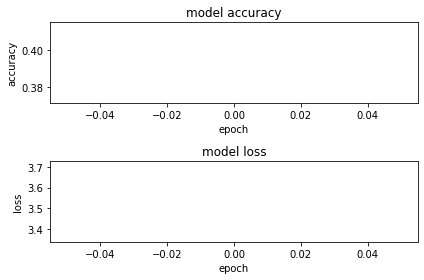

In [328]:
plt.figure(1)
# summarize history for accuracy
plt.subplot(211)
plt.plot(history.history['categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch') 

# summarize history for loss
plt.subplot(212)
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.tight_layout()
plt.show()

In [329]:
# Your encoder_model and decoder_model here!
## Testing - Again, separate the encoder-decoder for teacher forcing...
# Part 1 - make the encoder
# Make just a model out of the encoder
# input = encoder_input (Input layer)
# output = encoder_states (enc Hidden layer * 2)
encoder_model = keras.Model(encoder_input, encoder_states)
# Part 2 - make the decoder
# Make just a model out of the decoder
# input = encoder_states (enc Hidden layer * 2)
# output = decoder_output
decoder_state_input_h = keras.layers.Input(shape=(hidden_size,))
decoder_state_input_c = keras.layers.Input(shape=(hidden_size,))
# Connect hidden to input(s)
decoder_states_input = [decoder_state_input_h, decoder_state_input_c]
decoder_hidden_output, decoder_state_h, decoder_state_c = decoder_hidden(
 decoder_input, initial_state=decoder_states_input)
decoder_states = [decoder_state_h, decoder_state_c]
# Connect output to hidden(s)
decoder_output = decoder_dense(decoder_hidden_output)
decoder_model = keras.Model(
 [decoder_input] + decoder_states_input,
 [decoder_output] + decoder_states)

In [330]:
# Get the gestalt context for the input sequence(s)
i = 0
context = encoder_model.predict(X[i:i+1,:,:])
# Prep a starting token...
token = encode_seq('',stoi)[0].reshape(1,1,len(stoi))
token

array([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0.]]], dtype=float32)

In [331]:
# What should we see?
print('Input:', text[i])
print('Output:', text[i+1])

Input: It
Output: is


In [332]:
result = np.zeros([1,postY.shape[1],postY.shape[2]])
for x in range(postY.shape[1]):
    out,h,c = decoder_model.predict([token]+context)
    token = np.round(out)
    context = [h,c]
    result[:,x,:] = token
decode_seq(result[0,:,:],itos)

'is'

In [334]:
# Iterate - teacher forcing through each line
for i in range(0,500):
    # Get the gestalt context for the input sequence(s)
    context = encoder_model.predict(X[i:i+1,:,:])
    # Prep a starting token...
    token = encode_seq('',stoi)[0].reshape(1,1,len(stoi))
    result = np.zeros([1,postY.shape[1],postY.shape[2]])
    for x in range(postY.shape[1]):
        out,h,c = decoder_model.predict([token]+context)
        token = np.round(out)
        context = [h,c]
        result[:,x,:] = token
    print('Txt:',text[i+1])
    print('Net:',decode_seq(result[0,:,:],itos))

Txt: is
Net: is
Txt: a
Net: o
Txt: truth
Net: ar
Txt: universally
Net: universally
Txt: acknowledged,
Net: acknowledged,
Txt: that
Net: that
Txt: a
Net: he
Txt: single
Net: ar
Txt: man
Net: man
Txt: in
Net: o
Txt: possession
Net: enerome
Txt: of
Net: before
Txt: a
Net: 
Txt: good
Net: ar
Txt: fortune,
Net: fortune,
Txt: must
Net: must
Txt: be
Net: ise
Txt: in
Net: nthing
Txt: want
Net: enerome
Txt: of
Net: to
Txt: a
Net: 
Txt: wife.
Net: ar
Txt: However
Net: However
Txt: little
Net: little
Txt: known
Net: known
Txt: the
Net: the
Txt: feelings
Net: rth
Txt: or
Net: or
Txt: views
Net: ingle?"
Txt: of
Net: of
Txt: such
Net: 
Txt: a
Net: a
Txt: man
Net: ar
Txt: may
Net: o
Txt: be
Net: end
Txt: on
Net: nthing
Txt: his
Net: at
Txt: first
Net: arying
Txt: entering
Net: entering
Txt: a
Net: a
Txt: neighbourhood,
Net: ar
Txt: this
Net: this
Txt: truth
Net: truth
Txt: is
Net: universally
Txt: so
Net: o
Txt: well
Net: ervent
Txt: fixed
Net: fixed
Txt: in
Net: in
Txt: the
Net: enerome
Txt: minds
N

In [338]:
# Iterate - but no teaching forcing past first line...
# Get the gestalt context for the input sequence
i = 0
context = encoder_model.predict(X[i:i+1,:,:])
for i in range(0,500):
    # Prep a starting token...
    token = encode_seq('',stoi)[0].reshape(1,1,len(stoi))

    result = np.zeros([1,postY.shape[1],postY.shape[2]]) 
    for x in range(postY.shape[1]):
        out,h,c = decoder_model.predict([token]+context)
        token = np.round(out)
        context = [h,c]
        result[:,x,:] = token
    print('Txt:',text[i+1])
    print('Net:',decode_seq(result[0,:,:],itos))
    # CRUCIAL -> keep predicted result instead of teacher forcing!
    context = encoder_model.predict(result)

Txt: is
Net: is
Txt: a
Net: 
Txt: truth
Net: 
Txt: universally
Net: 
Txt: acknowledged,
Net: 
Txt: that
Net: 
Txt: a
Net: 
Txt: single
Net: 
Txt: man
Net: 
Txt: in
Net: 
Txt: possession
Net: 
Txt: of
Net: 
Txt: a
Net: 
Txt: good
Net: 
Txt: fortune,
Net: 
Txt: must
Net: 
Txt: be
Net: 
Txt: in
Net: 
Txt: want
Net: 
Txt: of
Net: 
Txt: a
Net: 
Txt: wife.
Net: 
Txt: However
Net: 
Txt: little
Net: 
Txt: known
Net: 
Txt: the
Net: 
Txt: feelings
Net: 
Txt: or
Net: 
Txt: views
Net: 
Txt: of
Net: 
Txt: such
Net: 
Txt: a
Net: 
Txt: man
Net: 
Txt: may
Net: 
Txt: be
Net: 
Txt: on
Net: 
Txt: his
Net: 
Txt: first
Net: 
Txt: entering
Net: 
Txt: a
Net: 
Txt: neighbourhood,
Net: 
Txt: this
Net: 
Txt: truth
Net: 
Txt: is
Net: 
Txt: so
Net: 
Txt: well
Net: 
Txt: fixed
Net: 
Txt: in
Net: 
Txt: the
Net: 
Txt: minds
Net: 
Txt: of
Net: 
Txt: the
Net: 
Txt: surrounding
Net: 
Txt: families,
Net: 
Txt: that
Net: 
Txt: he
Net: 
Txt: is
Net: 
Txt: considered
Net: 
Txt: the
Net: 
Txt: rightful
Net: 
Txt: property
N